# Notebook error analysis 

## Manual labels of the sampled errors for each cluster

in terms of bug types and root causes

In [20]:
# import importlib
# importlib.reload(config)
# import config

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


# 1. Prepare statistics

In [1]:
import pandas as pd
import config
import numpy as np
#what have been labeled
df_mlerr_labels_1 = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_labeled.xlsx'),
                                sheet_name = "Yiran",
                                keep_default_na=False)
df_mlerr_labels_1 = df_mlerr_labels_1[df_mlerr_labels_1.label_ML_pipeline != ""]
df_mlerr_labels_2 = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_labeled.xlsx'),
                                sheet_name = "Jose",
                                keep_default_na=False)
df_mlerr_labels_2 = df_mlerr_labels_2[df_mlerr_labels_2.label_ML_pipeline != ""]
df_mlerr_labels_3 = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_labeled.xlsx'),
                                sheet_name = "Willem",
                                keep_default_na=False)
df_mlerr_labels_3 = df_mlerr_labels_3[df_mlerr_labels_3.label_ML_pipeline != ""]
df_mlerr_labels = pd.concat([df_mlerr_labels_1, df_mlerr_labels_2, df_mlerr_labels_3], ignore_index=True)
df_mlerr_label_config = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_labeled.xlsx'),
                                sheet_name = "Config",
                                keep_default_na=False)

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [2]:
# need to take care of n/a in df_mlerr_label_config (label_refined_exp_type)!!!!!!
# it means the same as the enames

df_mlerr_labels['label_refined_exp_type'] = np.where(df_mlerr_labels['label_refined_exp_type'] == 'n/a', 
                                                     df_mlerr_labels['ename'], 
                                                     df_mlerr_labels['label_refined_exp_type'])
real_refined_exp_types = set(df_mlerr_label_config.label_refined_exp_type).union(set(df_mlerr_labels['label_refined_exp_type'].unique()))
real_refined_exp_types.remove("n/a")
real_refined_exp_types=list(real_refined_exp_types)
for _ in range(len(df_mlerr_label_config)-len(real_refined_exp_types)):
    real_refined_exp_types.append(np.nan)
for _ in range(len(real_refined_exp_types)-len(df_mlerr_label_config)):
    df_mlerr_label_config.loc[len(df_mlerr_label_config)] = pd.Series(dtype='float64')

df_mlerr_label_config['label_refined_exp_type'] = list(real_refined_exp_types)

In [3]:
assert(df_mlerr_labels.label_refined_exp_type.nunique()==len(df_mlerr_label_config.label_refined_exp_type))

In [4]:
df_mlerr_labels_g = df_mlerr_labels[df_mlerr_labels["nb_source"]==config.NB_SOURCE["github"]].reset_index(drop=True)
df_mlerr_labels_k = df_mlerr_labels[df_mlerr_labels["nb_source"]==config.NB_SOURCE["kaggle"]].reset_index(drop=True)
assert(len(df_mlerr_labels_g)+len(df_mlerr_labels_k)==len(df_mlerr_labels))

In [5]:
import pickle

# summarize the statistics
def statistics_labels(df_mlerr_label_config, df_mlerr_labels):
    cluster_res = {}
    for label_key in df_mlerr_label_config:
        cluster_res[label_key] = {}

    df_mlerr_labeled_clusters = df_mlerr_labels.cluster_id.unique()
    for cluster_id in df_mlerr_labeled_clusters:
        cluster_errors = df_mlerr_labels[df_mlerr_labels.cluster_id == cluster_id]
        for label_key in df_mlerr_label_config:
            for label_key_option in df_mlerr_label_config[label_key].dropna():
                cluster_label_key_option_size = sum(cluster_errors[label_key]==label_key_option)
                if label_key_option not in cluster_res[label_key]:
                    cluster_res[label_key][label_key_option] = {}
                cluster_res[label_key][label_key_option][cluster_id] = (cluster_label_key_option_size, len(cluster_errors))
    return cluster_res

def save_statistics(save_path, cluster_res):
    with open(save_path, 'wb') as handle:
        pickle.dump(cluster_res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
cluster_res_g = statistics_labels(df_mlerr_label_config, df_mlerr_labels_g)
save_statistics(config.path_default.joinpath("data_dedup_cluster/sample4_statistics_g.pickle"), cluster_res_g)

cluster_res_k = statistics_labels(df_mlerr_label_config, df_mlerr_labels_k)
save_statistics(config.path_default.joinpath("data_dedup_cluster/sample4_statistics_k.pickle"), cluster_res_k)   

# 2. Analysis

distribution calculation based on all errors in the SELECTED clusters (not all errors in the dataset)

In [15]:
import pandas as pd
import config
import pickle
import matplotlib.pyplot as plt
from IPython.display import display

def load_statistics(load_path):
    with open(load_path, 'rb') as handle:
        cluster_res_load = pickle.load(handle)
    return cluster_res_load

df_mlerr_label_config = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_labeled.xlsx'),
                                sheet_name = "Config",
                                keep_default_na=False)

In [74]:
import math

def map_element_weights(x):
    if isinstance(x, tuple):
        return x[0]
    else:
        return x

# calculated/summed over all clusters, sorted
def cal_weighted_sum(df_mlerr_label_config, cluster_res):
    cluster_res_weighted_sum = {}
    for label_key in df_mlerr_label_config:
        cluster_res_weight = cluster_res[label_key].map(map_element_weights)
        cluster_res_weighted_sum[label_key] = cluster_res_weight.iloc[:, 1:].sum().sort_values(ascending=False)
    return cluster_res_weighted_sum

# plot weighted sum for all categories of labels for both sources
def plot_dist_labels(df_mlerr_label_config, cluster_res_weighted_sum_g, cluster_res_weighted_sum_k):
    for label_key in df_mlerr_label_config:
        fig, axs = plt.subplots(1, 2, figsize=(9, 12))
        cluster_res_weighted_sum_g[label_key].plot.pie(ax=axs[0], legend=True, labeldistance=None,
                                                     autopct='%1.1f%%', fontsize=7, 
                                                     title = "GitHub - "+label_key)
        cluster_res_weighted_sum_k[label_key].plot.pie(ax=axs[1], legend=False, labeldistance=None,
                                                       autopct='%1.1f%%', fontsize=7, 
                                                       title = "Kaggle - "+label_key)
        axs[0].legend(bbox_to_anchor=(2.3, 0), loc='lower left')
        plt.show()

In [162]:
# plot each cluster for all categories of labels
def agg_data_for_cluster_plot(df_mlerr_label_config, cluster_res, min_size = 10, source = "GitHub"):
    plot_cluster_res = {}
    remain_cluster_res = {}

    for label_key in df_mlerr_label_config:
        remain_n = 0
        for _, row in cluster_res_g[label_key].iterrows():
            if (row.iloc[1][1] < min_size) or (row.cluster_id in [-100,-200]):
                remain_n += row.iloc[1][1]
                if label_key not in remain_cluster_res:
                    remain_cluster_res[label_key] = []
                remain_cluster_res[label_key].append(row)
                
            else:
                if label_key not in plot_cluster_res:
                    plot_cluster_res[label_key] = []
                plot_cluster_res[label_key].append(row.map(map_element_weights))
        if label_key in remain_cluster_res:
            remain_cluster_res[label_key] = pd.DataFrame(remain_cluster_res[label_key])

    remain_cluster_res_sum = cal_weighted_sum(df_mlerr_label_config,(remain_cluster_res))

    for label_key in df_mlerr_label_config:
        assert(remain_n == sum(remain_cluster_res_sum[label_key]))
        remain_cluster_res_sum[label_key]["cluster_id"] = -2000 if source == "GitHub" else -1000
        plot_cluster_res[label_key].append(remain_cluster_res_sum[label_key])
        plot_cluster_res[label_key] = pd.DataFrame(plot_cluster_res[label_key]).reset_index(drop=True)
        
    return plot_cluster_res

def plot_dist_labels_clusters(df_mlerr_label_config, cluster_res, min_size = 10, source="GitHub"):
    
    plot_cluster_res = agg_data_for_cluster_plot(df_mlerr_label_config, cluster_res, min_size, source = "GitHub")
    
    n_clusters = len(plot_cluster_res[df_mlerr_label_config.columns[0]])
    
    for label_key in df_mlerr_label_config:
        fig, axs = plt.subplots(math.ceil(n_clusters/2), 2, figsize=(9, 6*math.ceil(n_clusters/2)))
        
        for i in range(0, n_clusters, 2):
            plot_cluster_res[label_key].iloc[i,1:].plot.pie(ax=axs[i//2,0], legend=False, labeldistance=None,
                                                     autopct='%1.1f%%', fontsize=7, 
                                                     title = source+" - "+str(plot_cluster_res[label_key].iloc[i,0])+label_key)
            if i+1 > math.ceil(n_clusters/2):
                break
            plot_cluster_res[label_key].iloc[i+1,1:].plot.pie(ax=axs[i//2,1], legend=False, labeldistance=None,
                                                     autopct='%1.1f%%', fontsize=7, 
                                                     title = source+" - "+str(plot_cluster_res[label_key].iloc[i+1,0])+label_key)
        #??? legend covered all
        handles_axs, labels_axs = set(),set()
        for ax in axs.flatten():
            handles, labels = ax.get_legend_handles_labels()
            handles_axs.update(handles)
            labels_axs.update(labels)
        axs[0,0].legend(handles_axs, labels_axs, bbox_to_anchor=(2.3, 0), loc='lower left')
        plt.show()

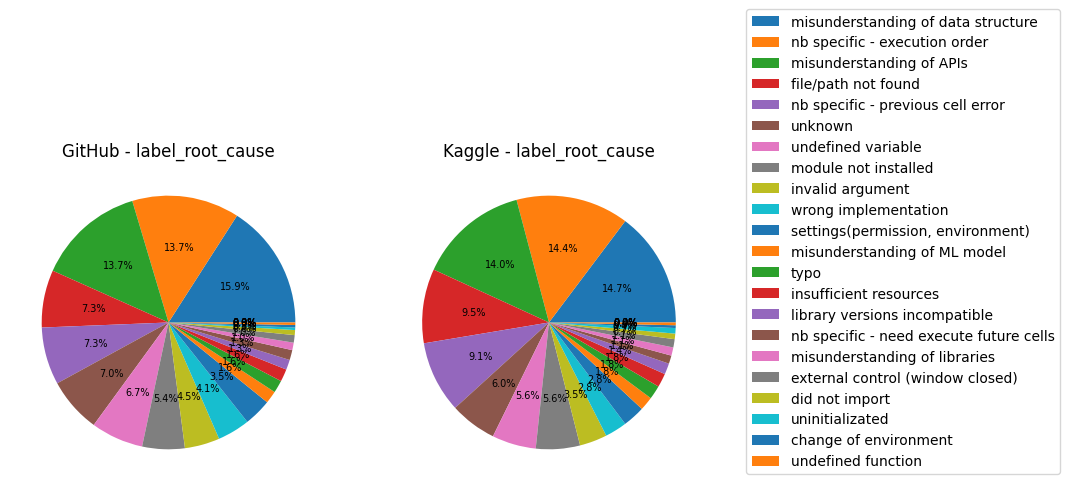

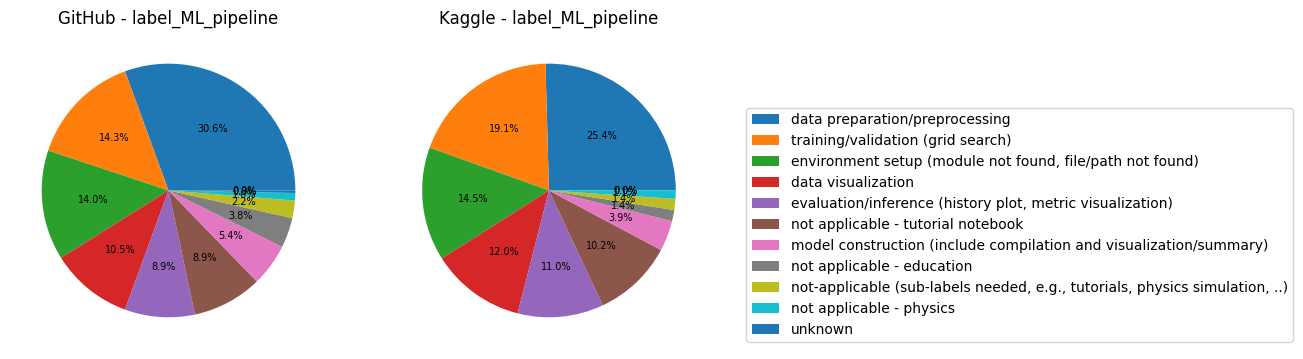

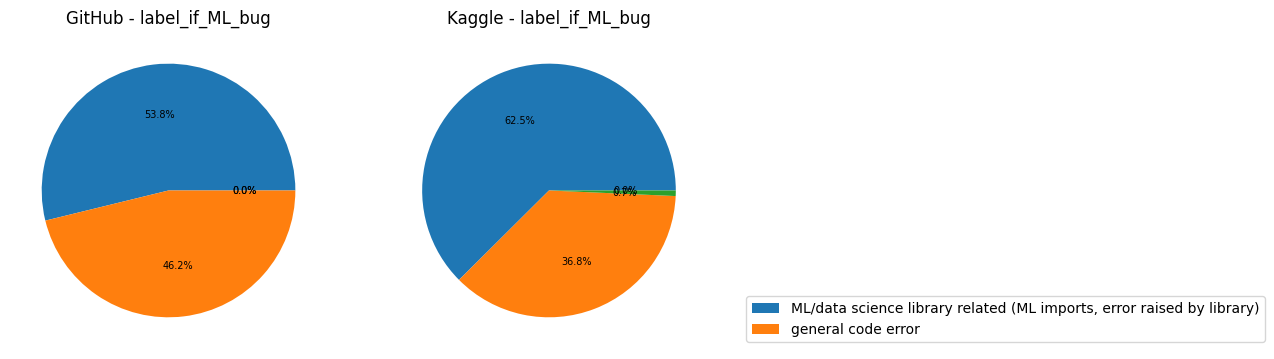

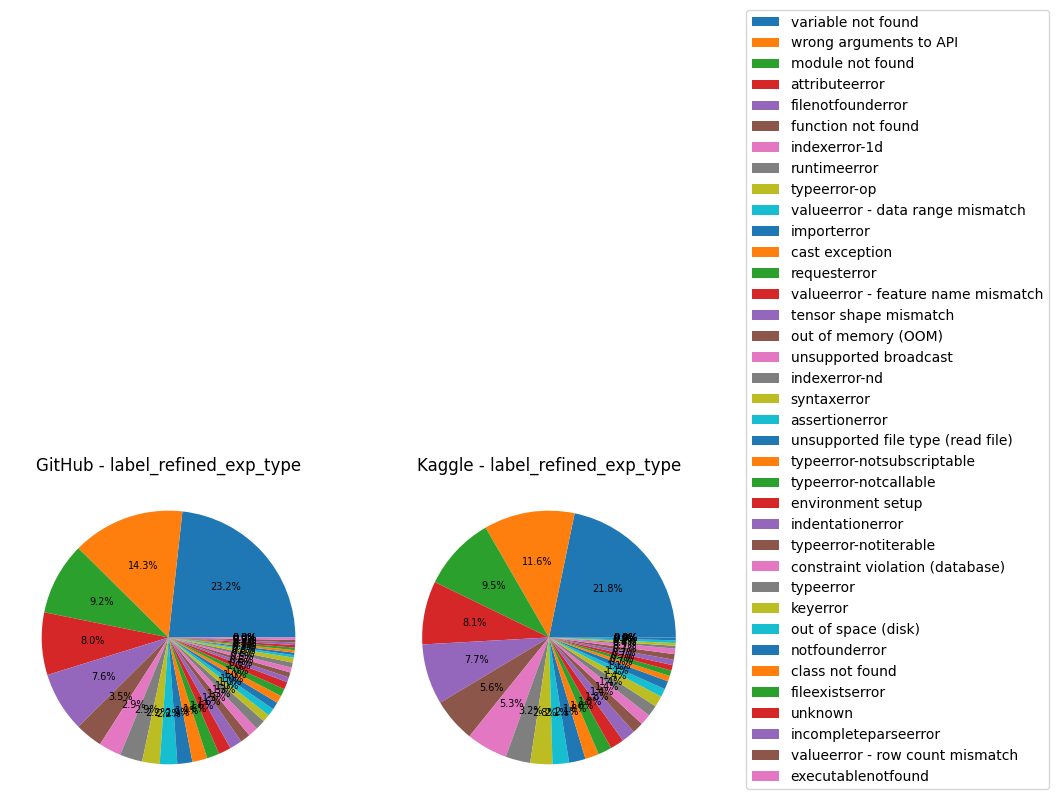

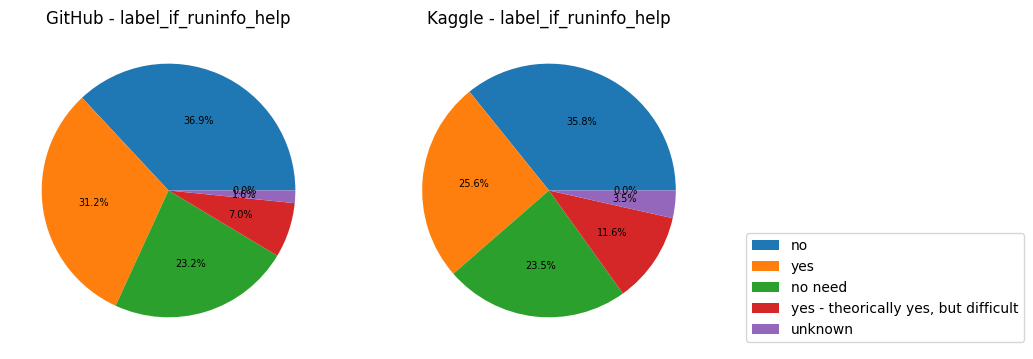

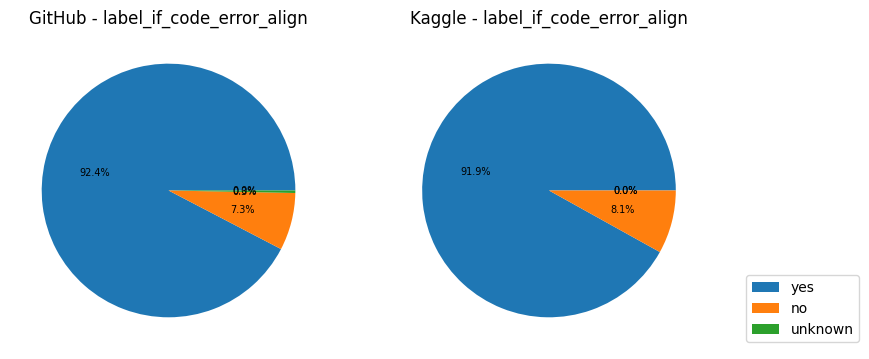

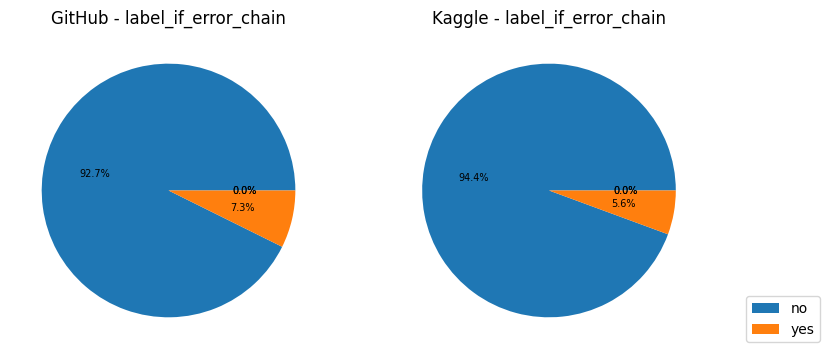

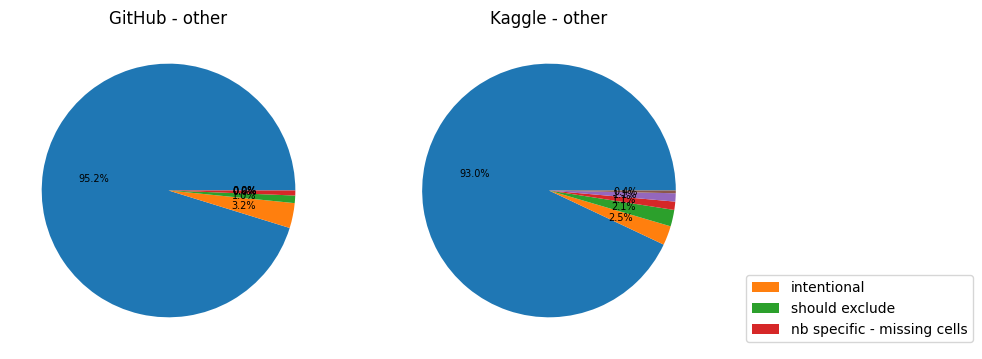

In [145]:
# plot across clusters, github kaggle side by side

# github stats
cluster_res_g = load_statistics(config.path_default.joinpath("data_dedup_cluster/sample4_statistics_g.pickle"))
for label_key in df_mlerr_label_config:
    cluster_res_g[label_key] = pd.DataFrame.from_dict(cluster_res_g[label_key]).rename_axis('cluster_id').reset_index()
# for all clusters    
cluster_res_g_weighted_sum = cal_weighted_sum(df_mlerr_label_config, cluster_res_g)

# kaggle stats
cluster_res_k = load_statistics(config.path_default.joinpath("data_dedup_cluster/sample4_statistics_k.pickle"))
for label_key in df_mlerr_label_config:
    cluster_res_k[label_key] = pd.DataFrame.from_dict(cluster_res_k[label_key]).rename_axis('cluster_id').reset_index()
cluster_res_k_weighted_sum = cal_weighted_sum(df_mlerr_label_config, cluster_res_k)

plot_dist_labels(df_mlerr_label_config, cluster_res_g_weighted_sum, cluster_res_k_weighted_sum)

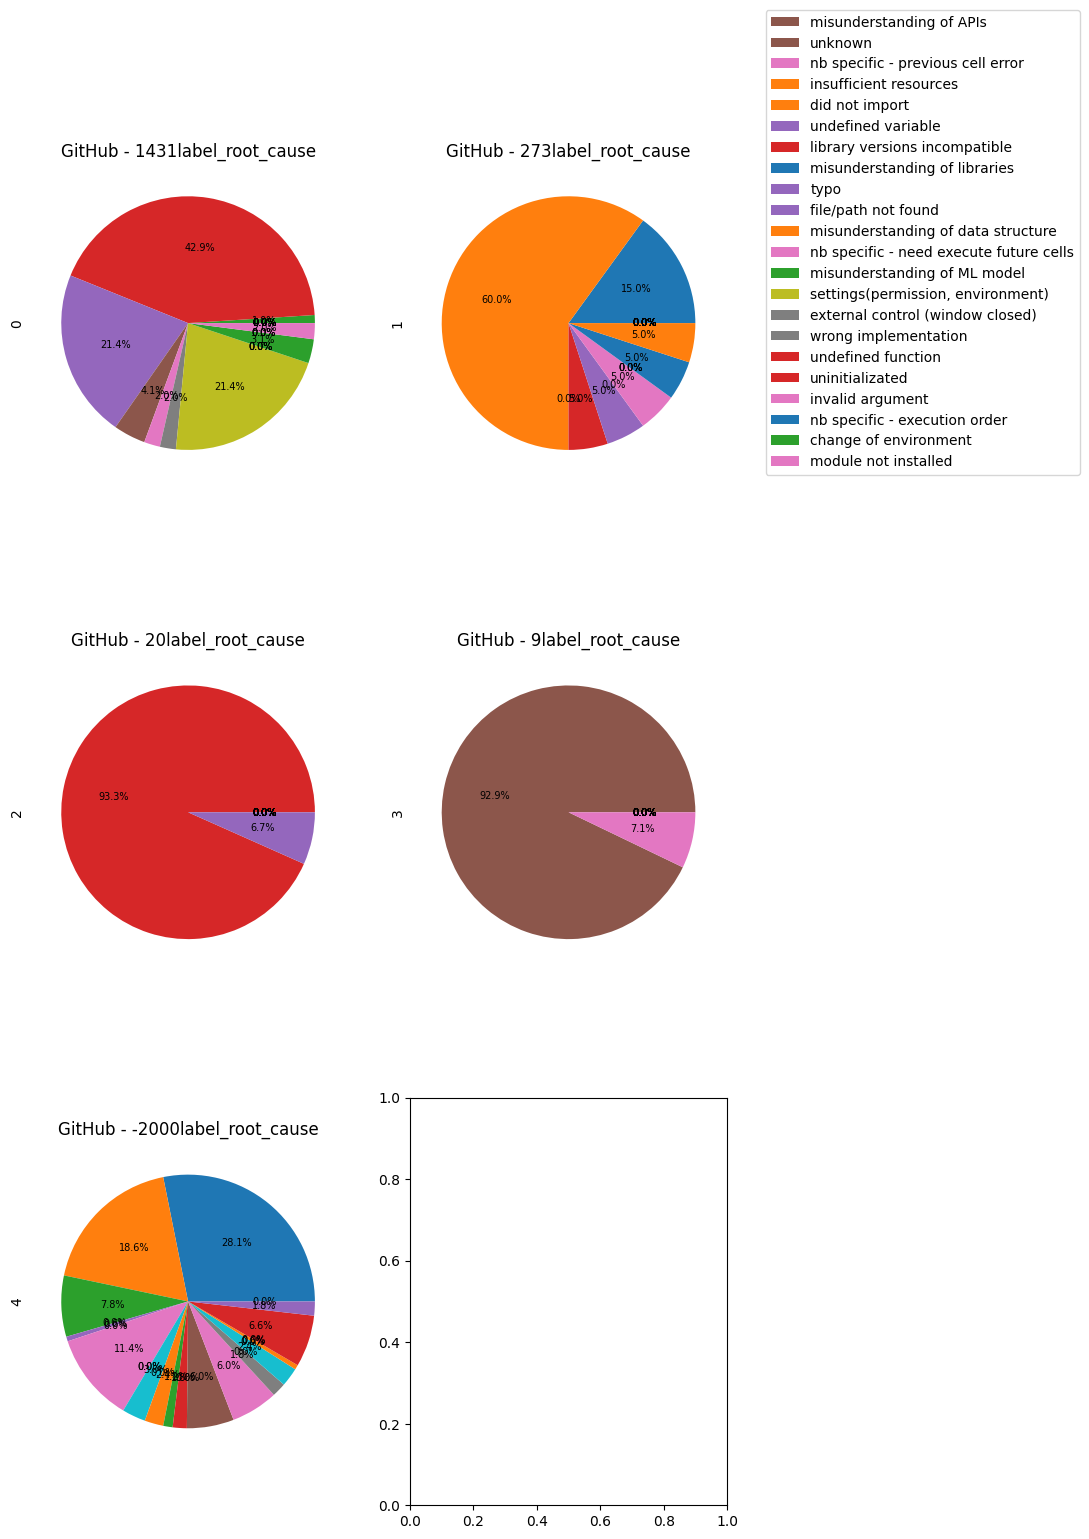

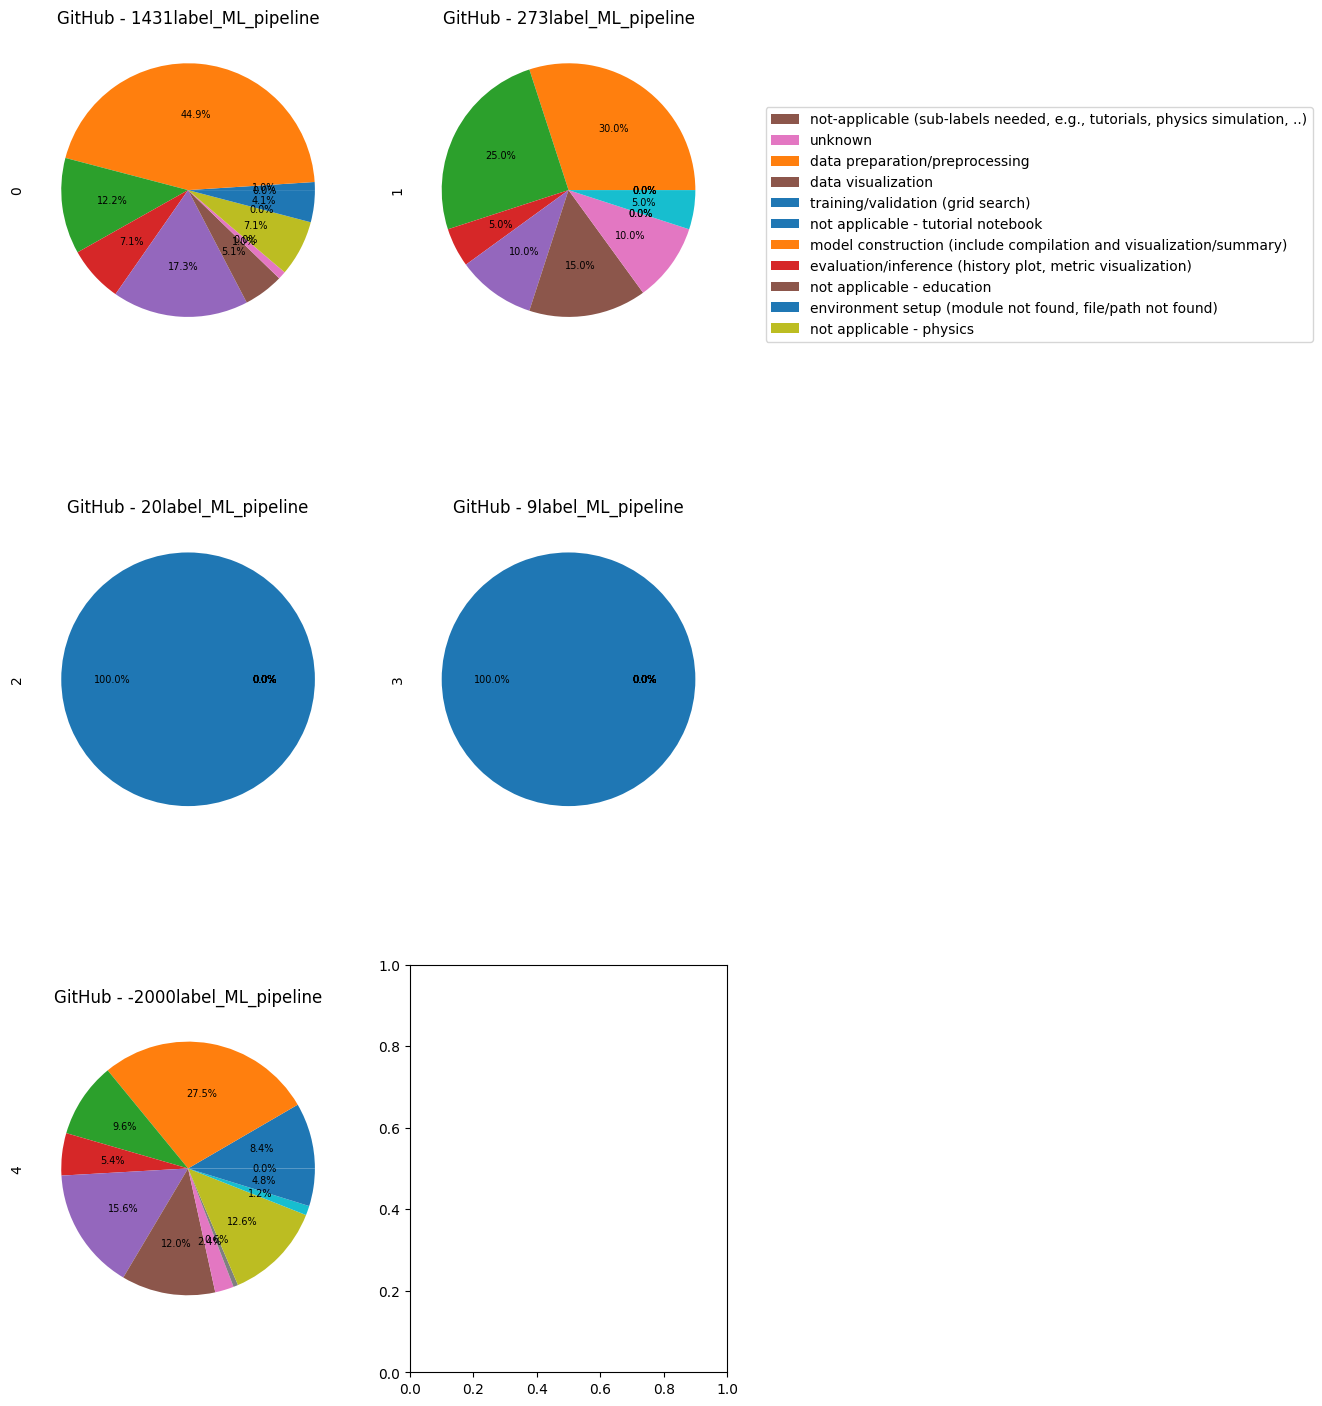

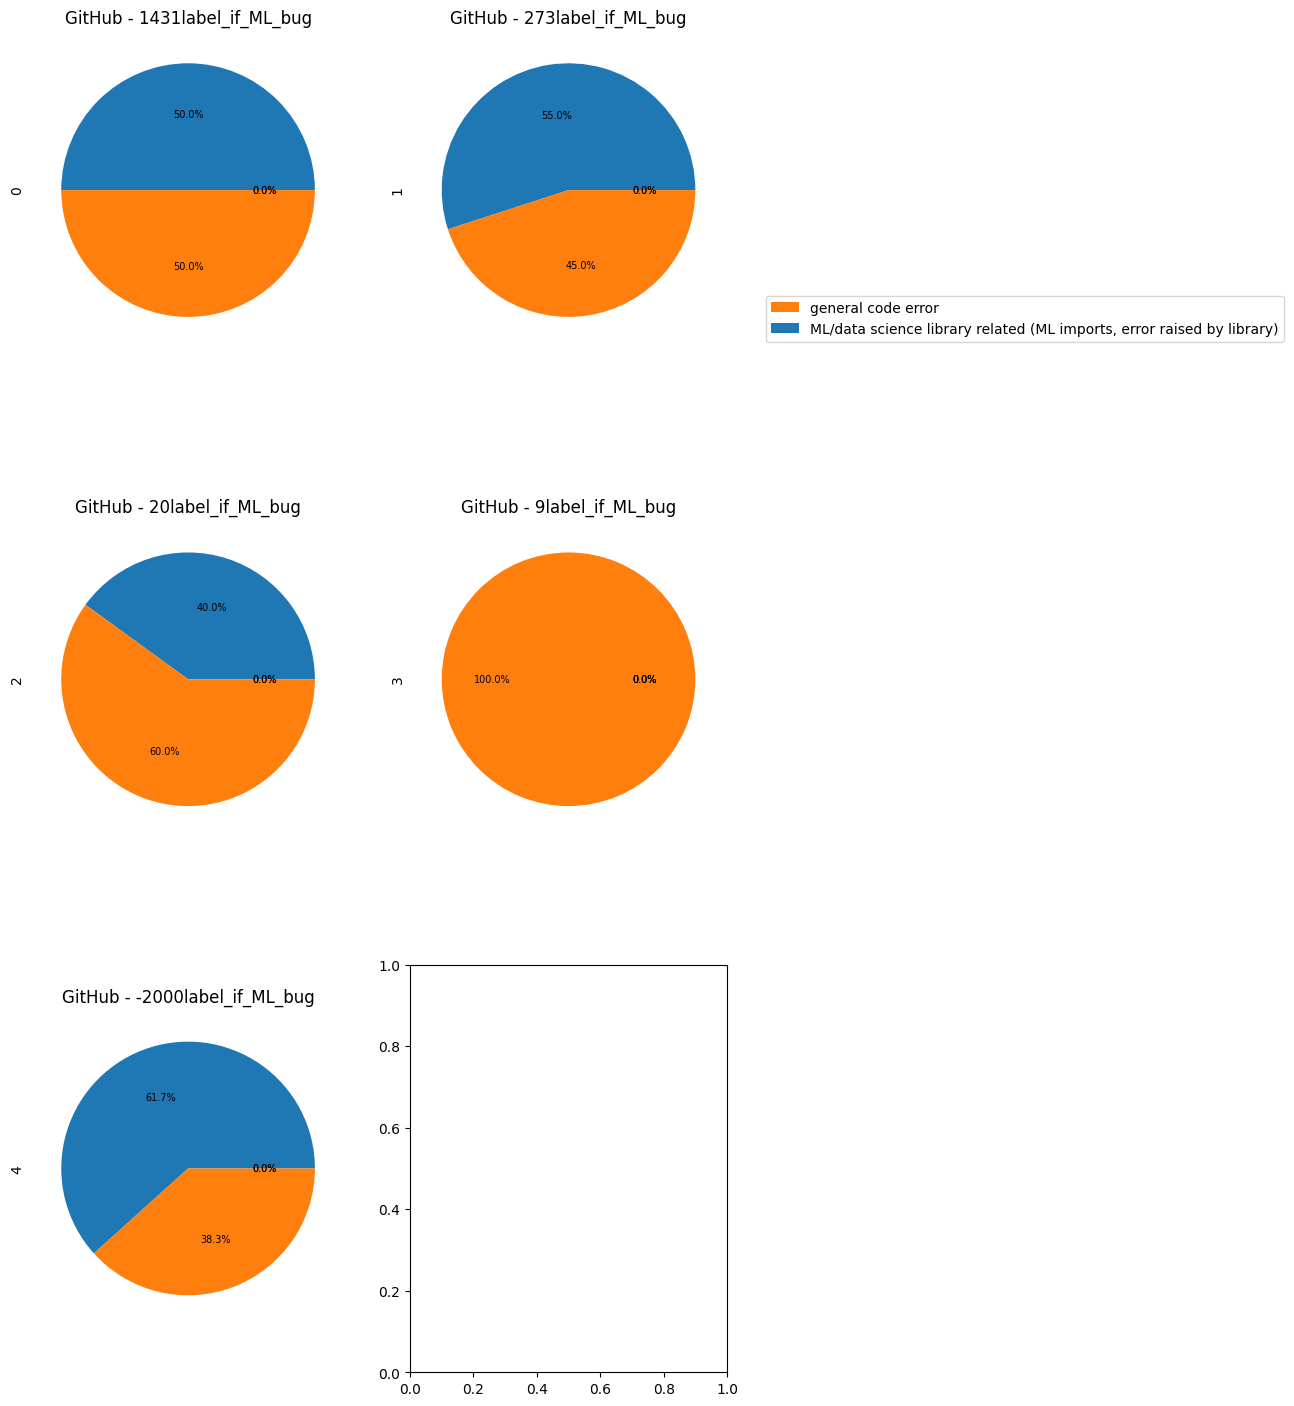

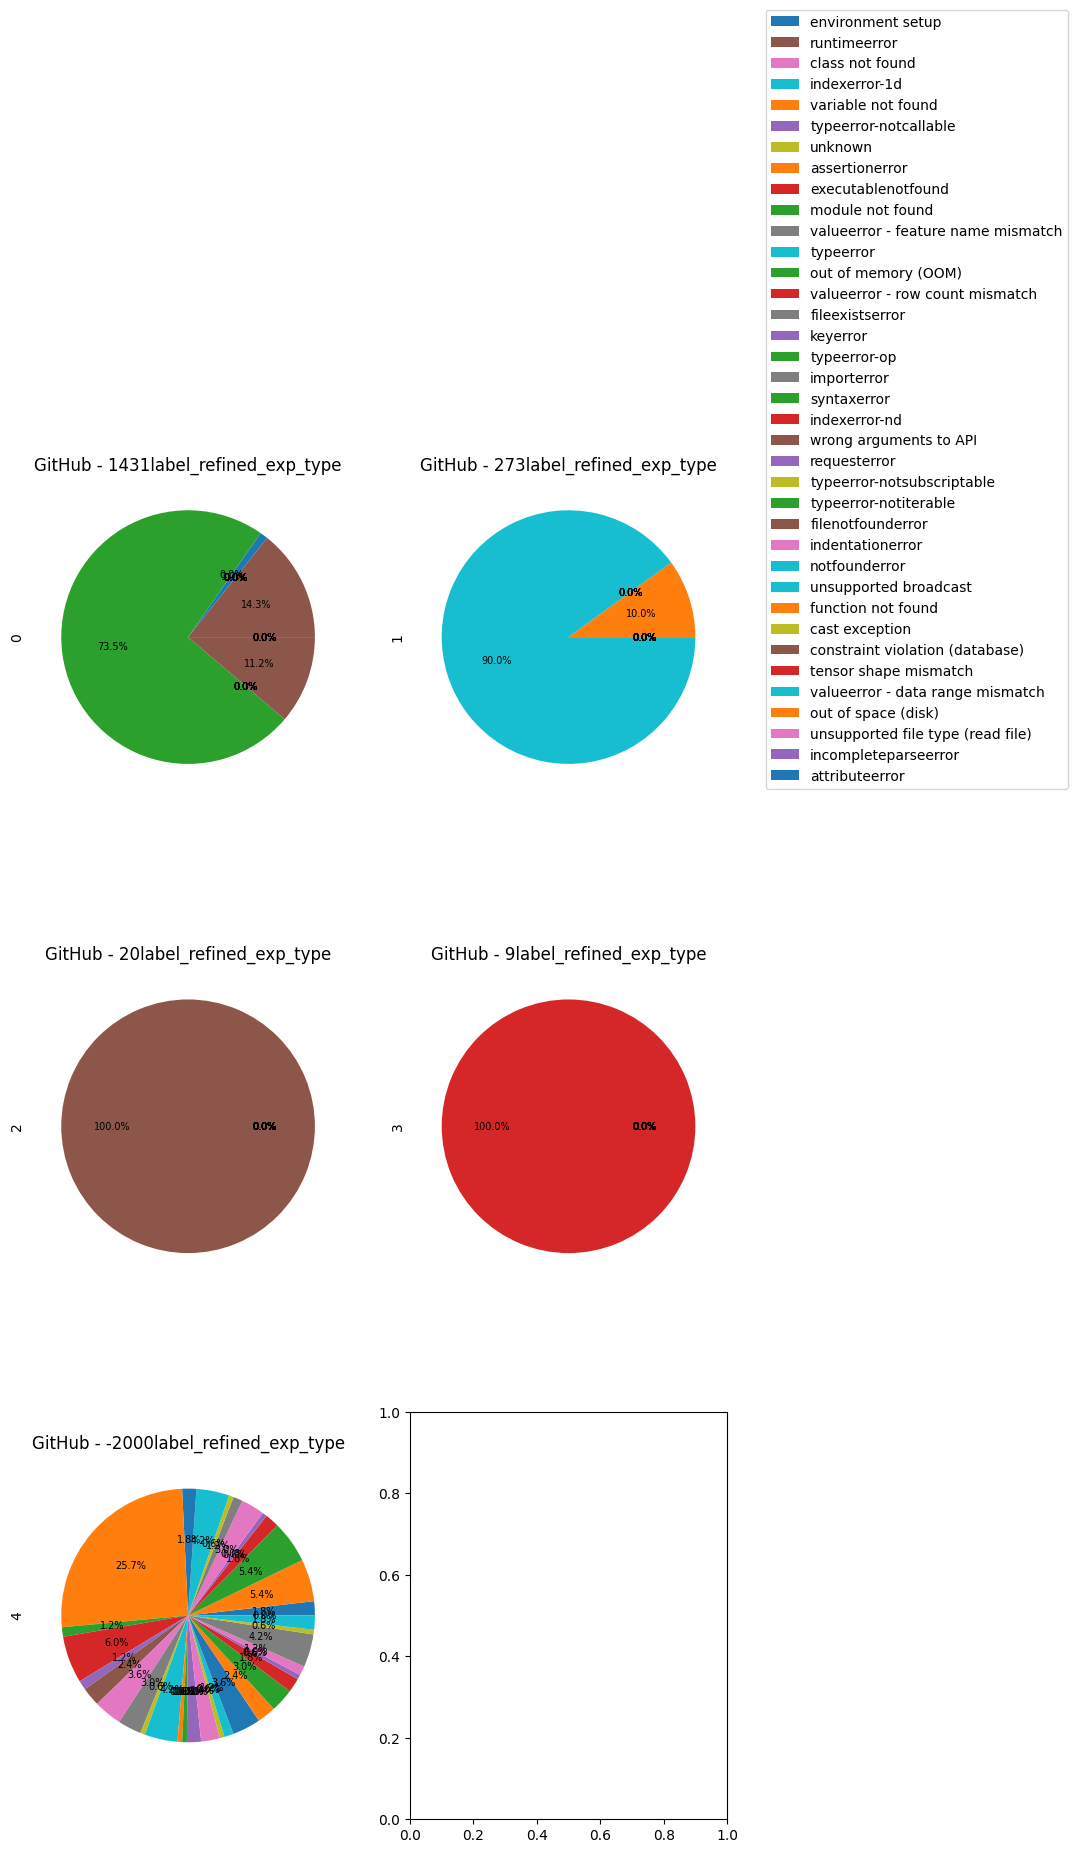

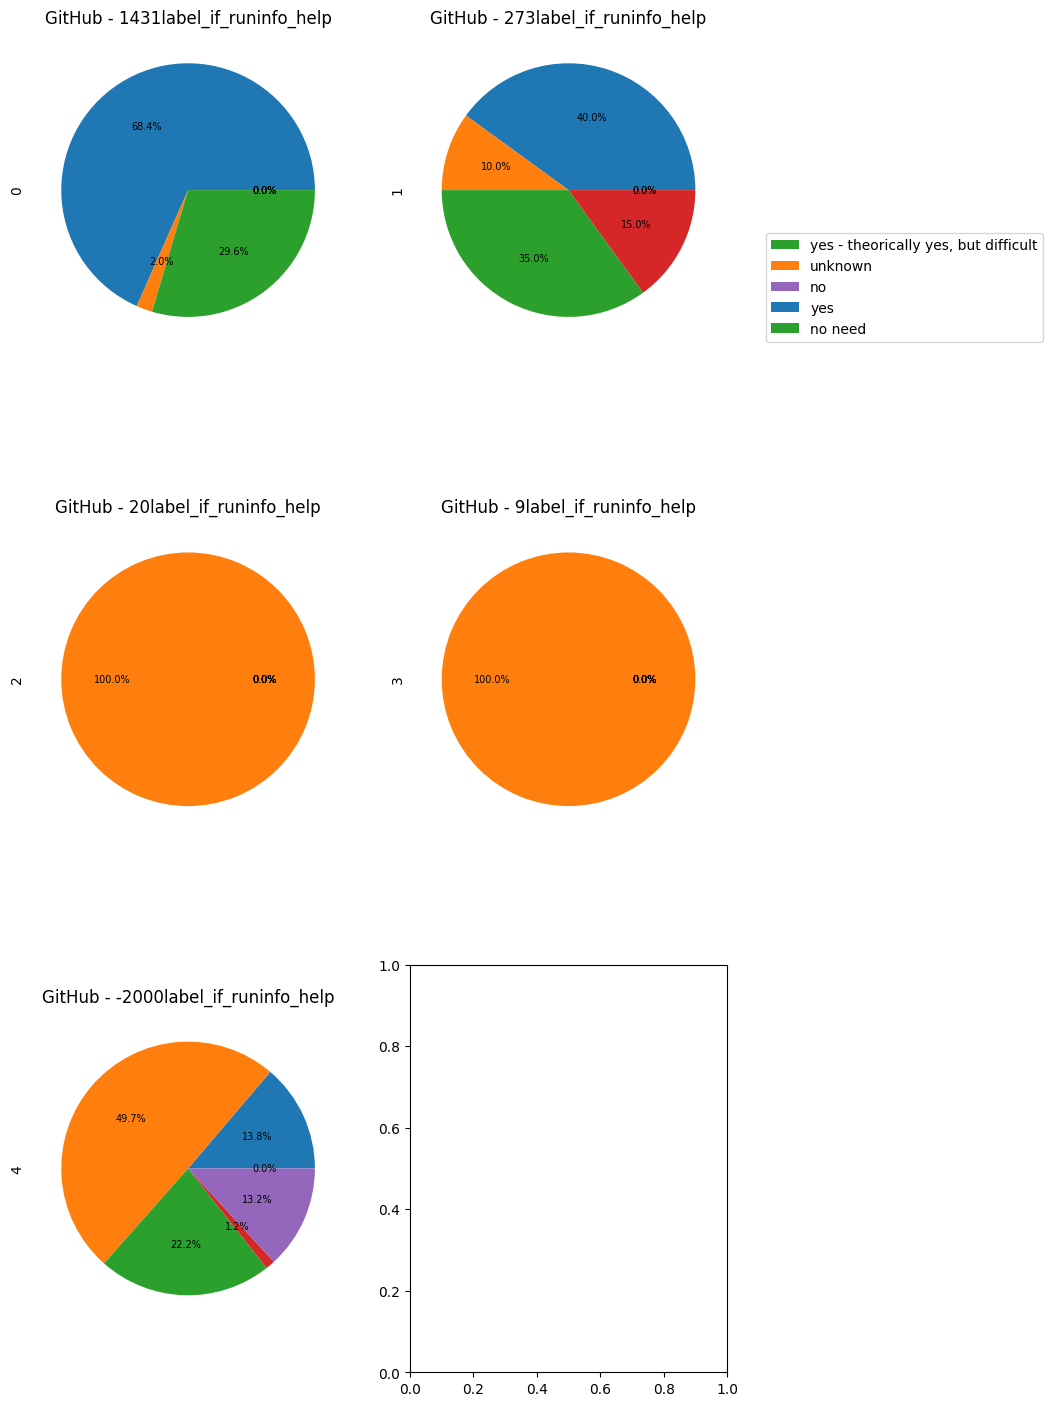

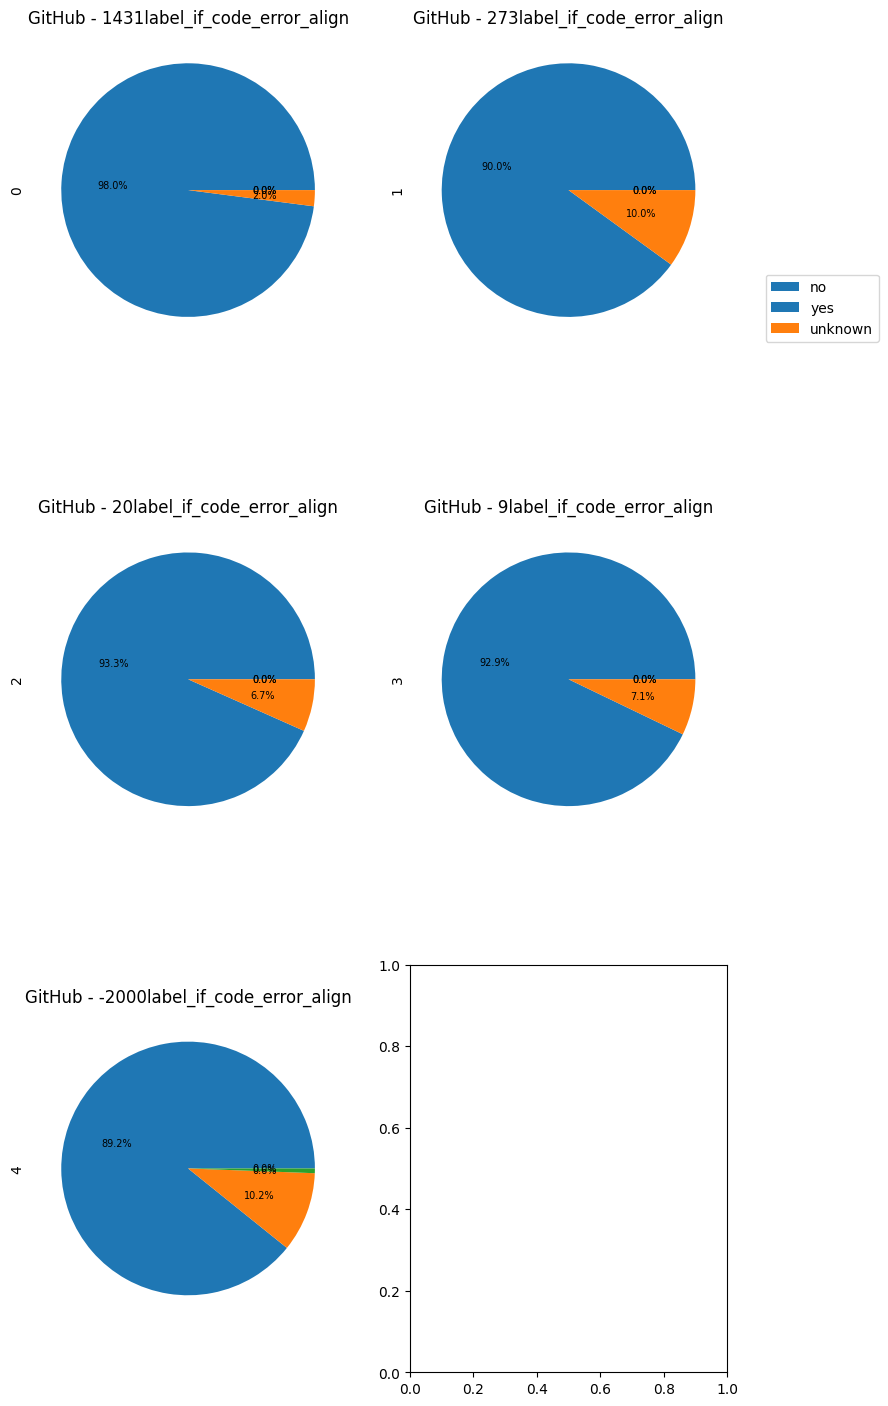

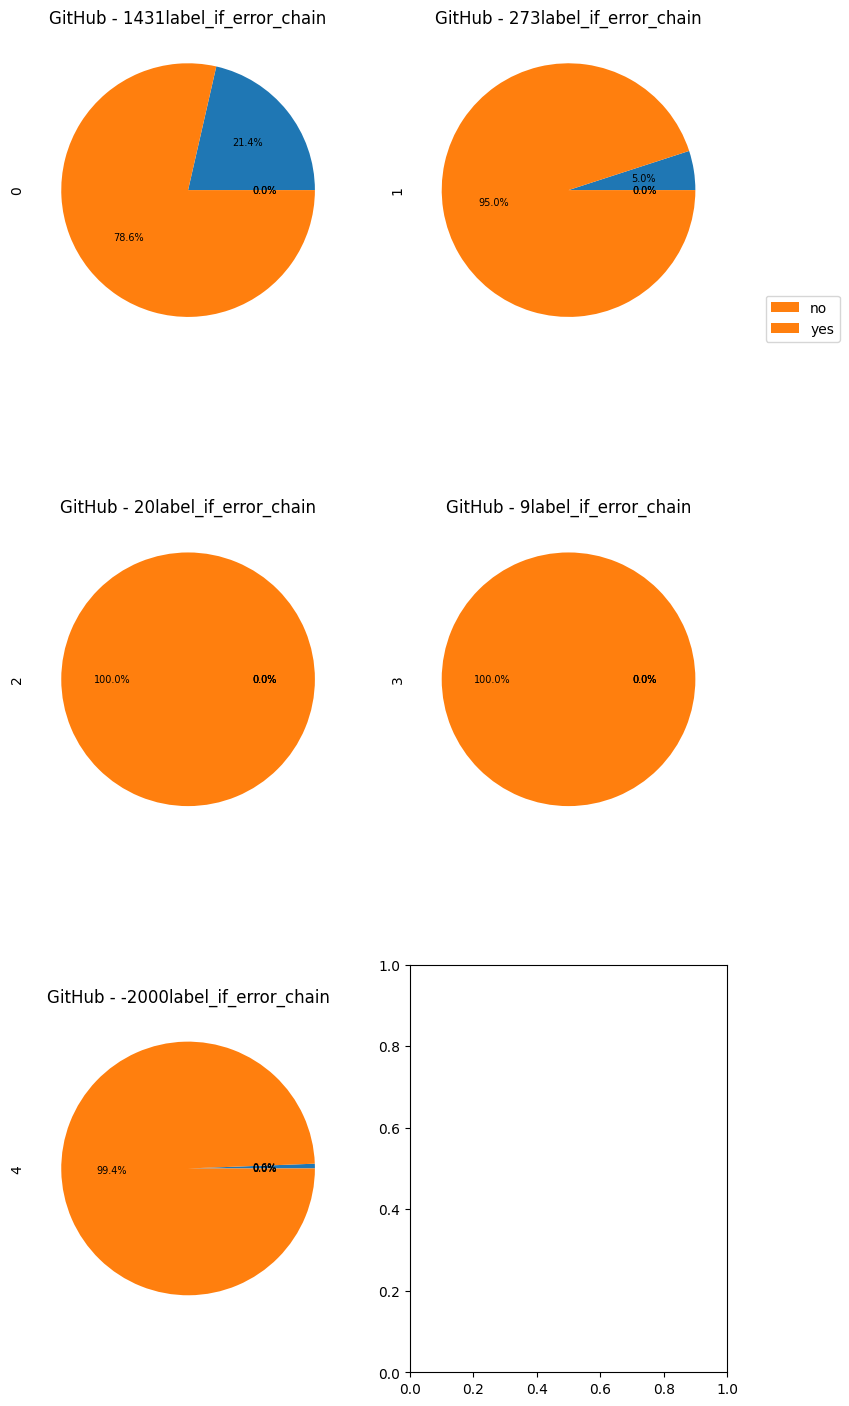

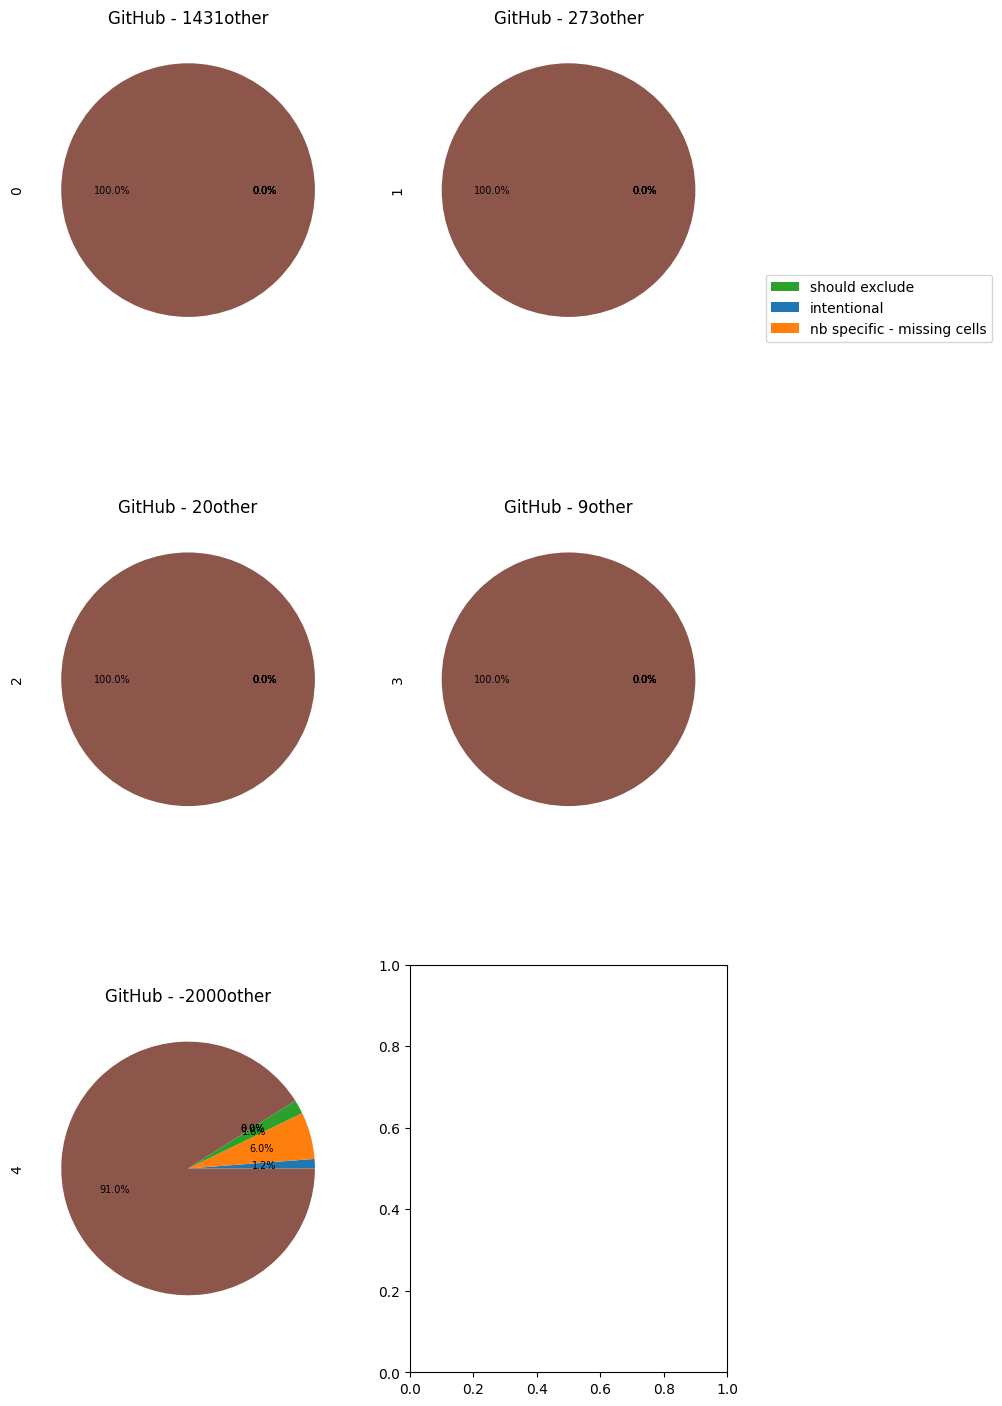

In [163]:
# plot Github labels based on clusters
plot_dist_labels_clusters(df_mlerr_label_config, cluster_res_g, source="GitHub")

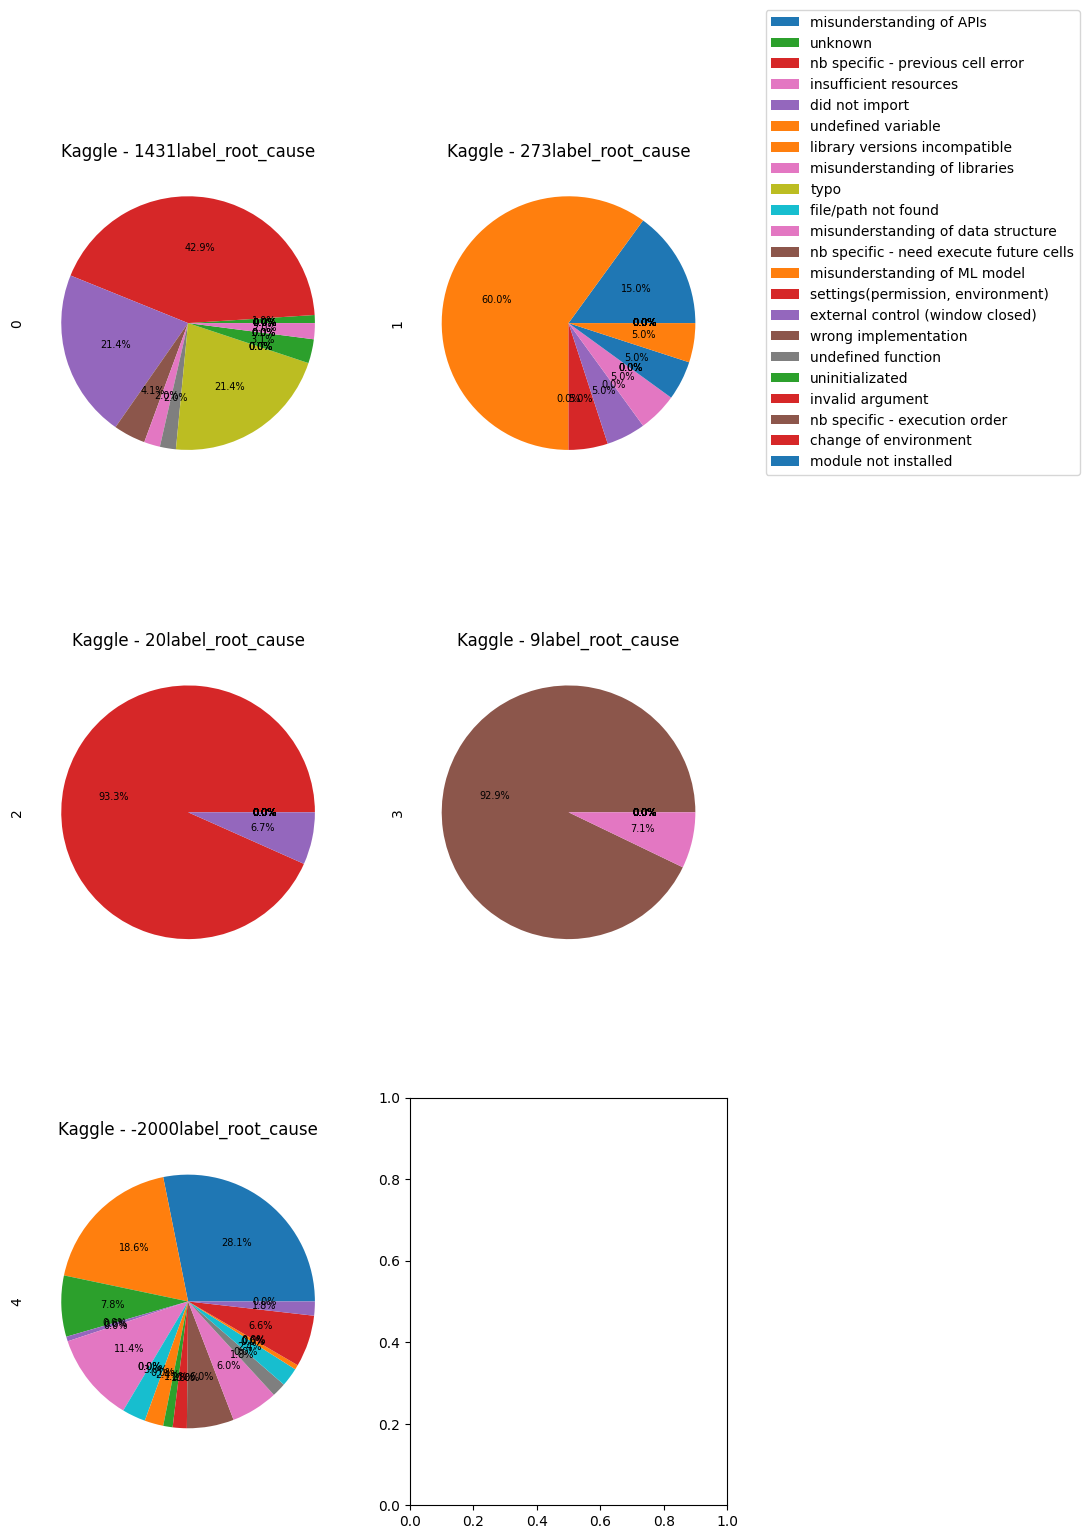

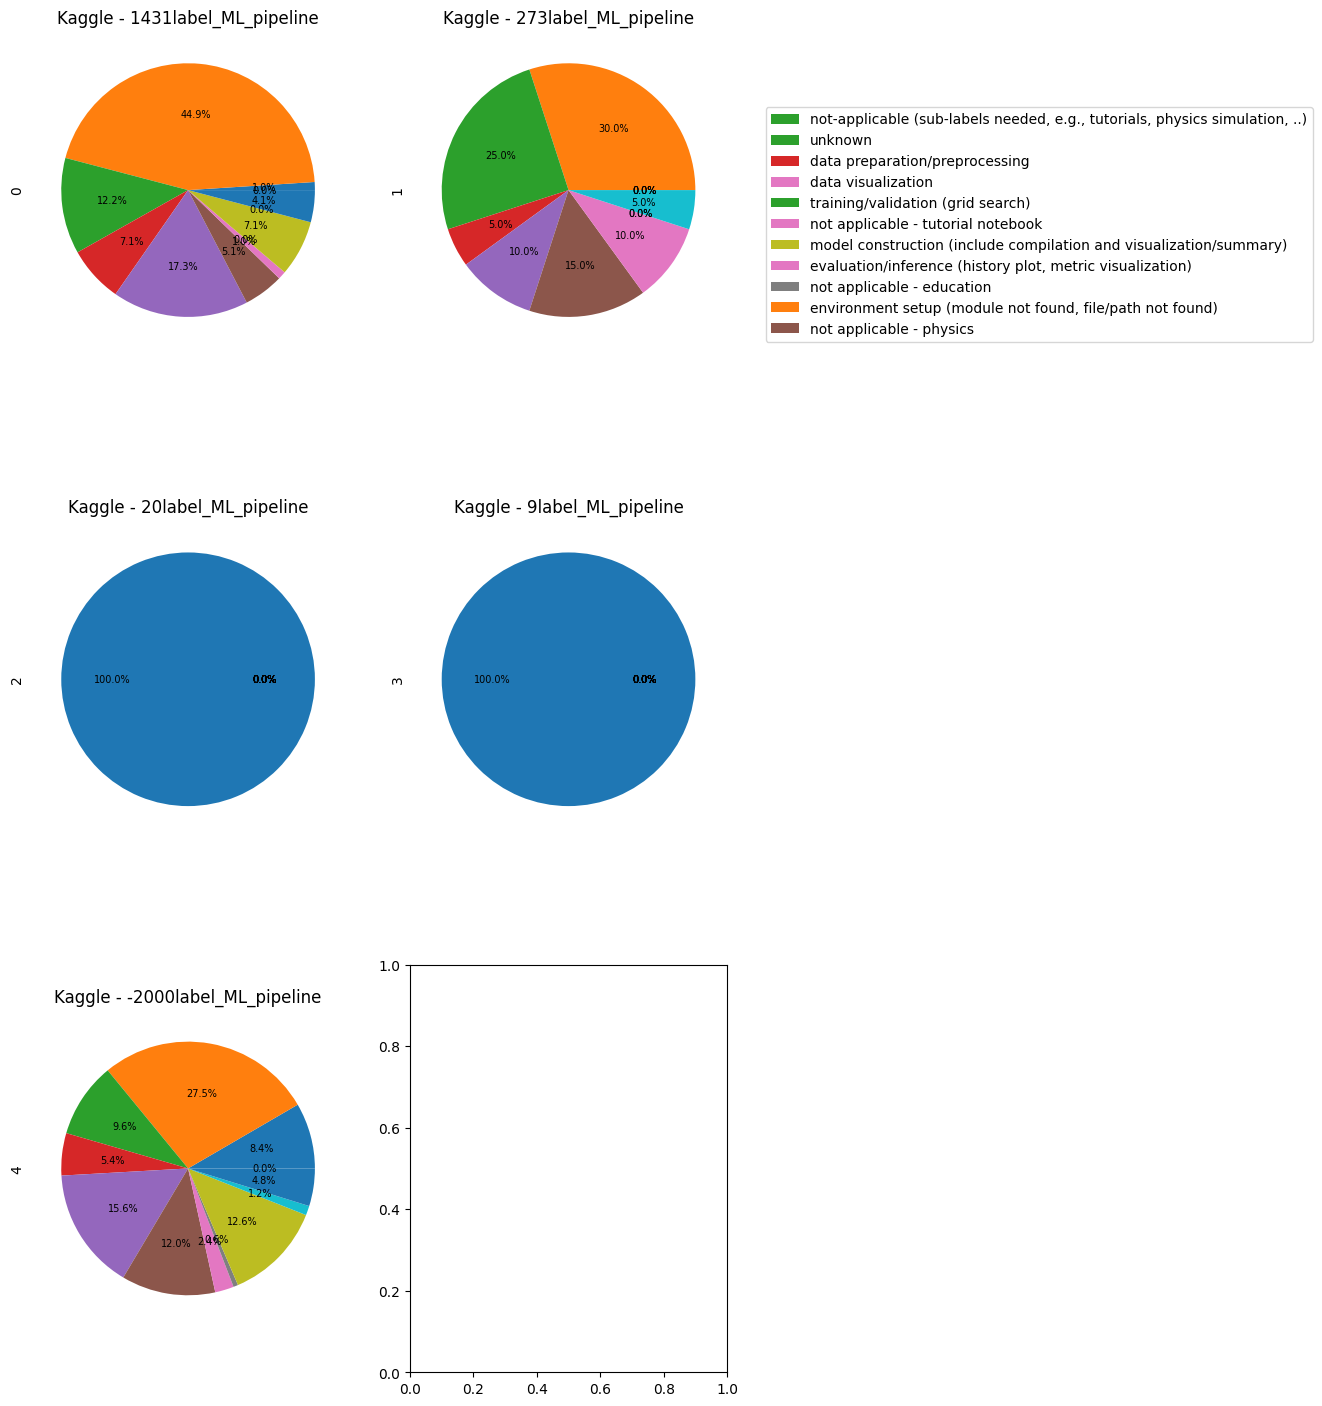

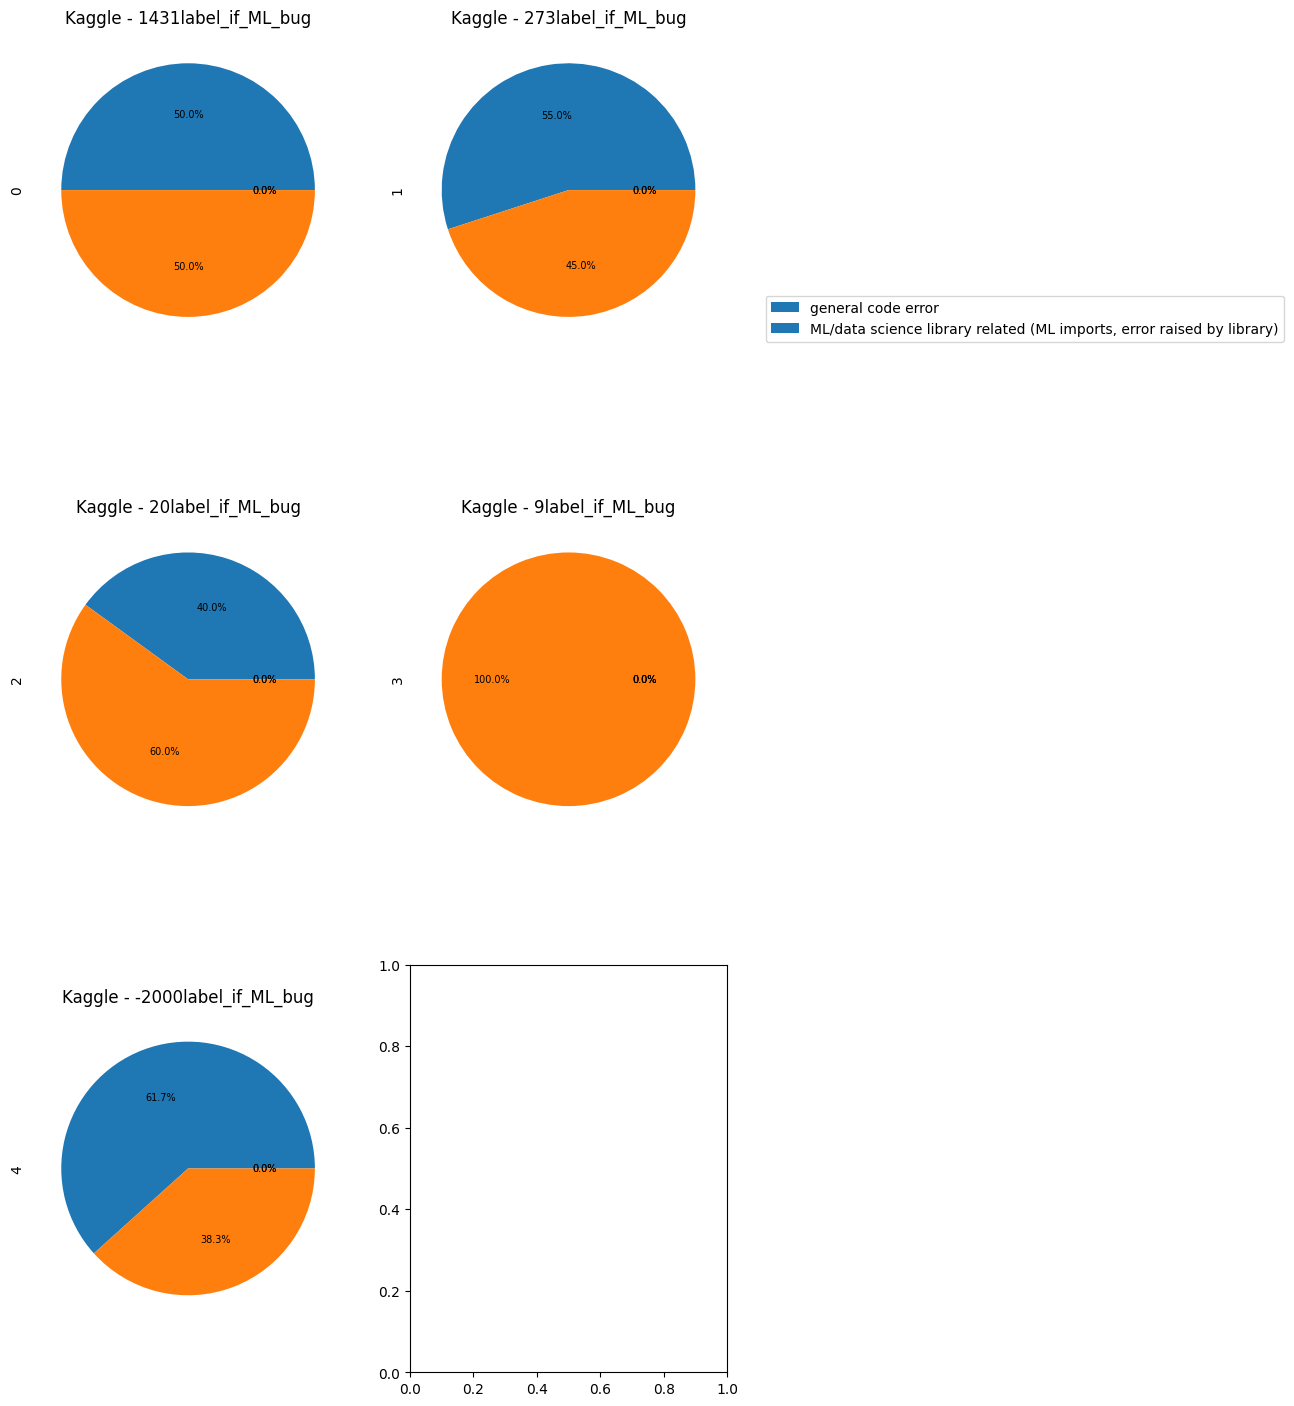

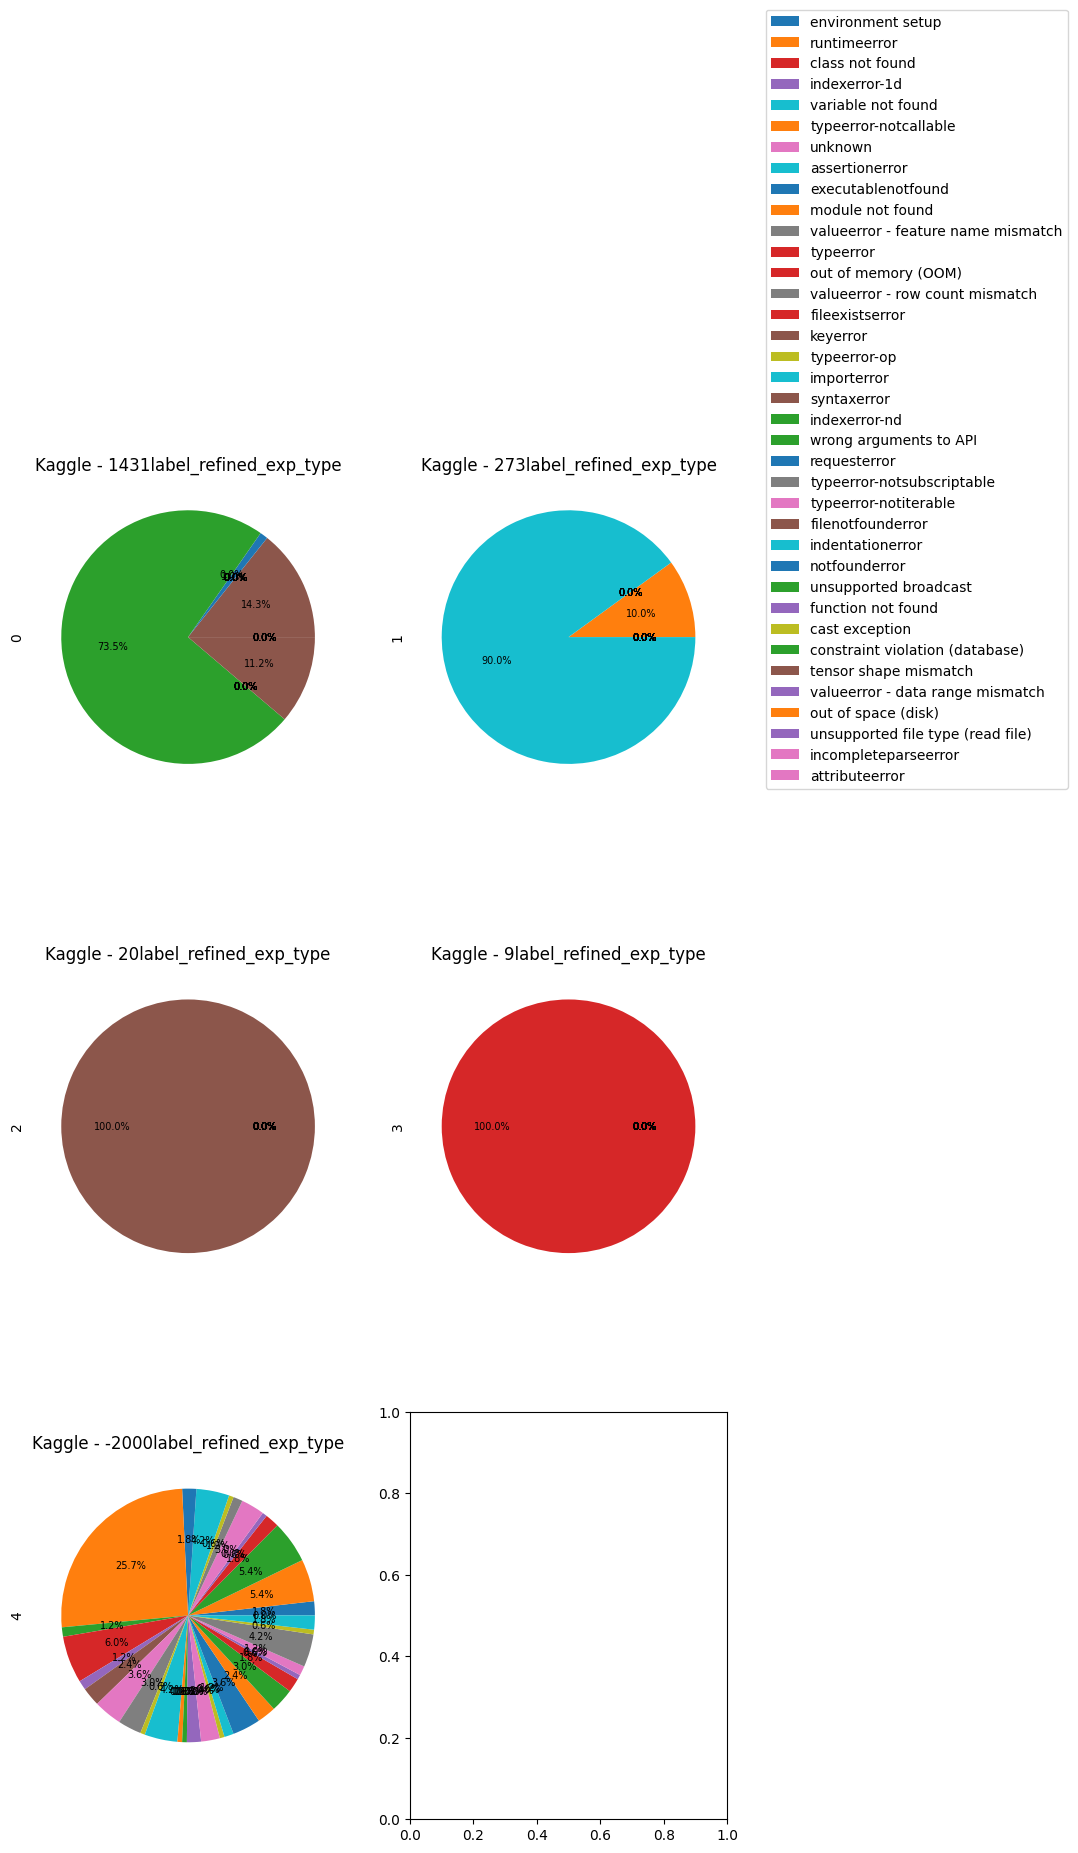

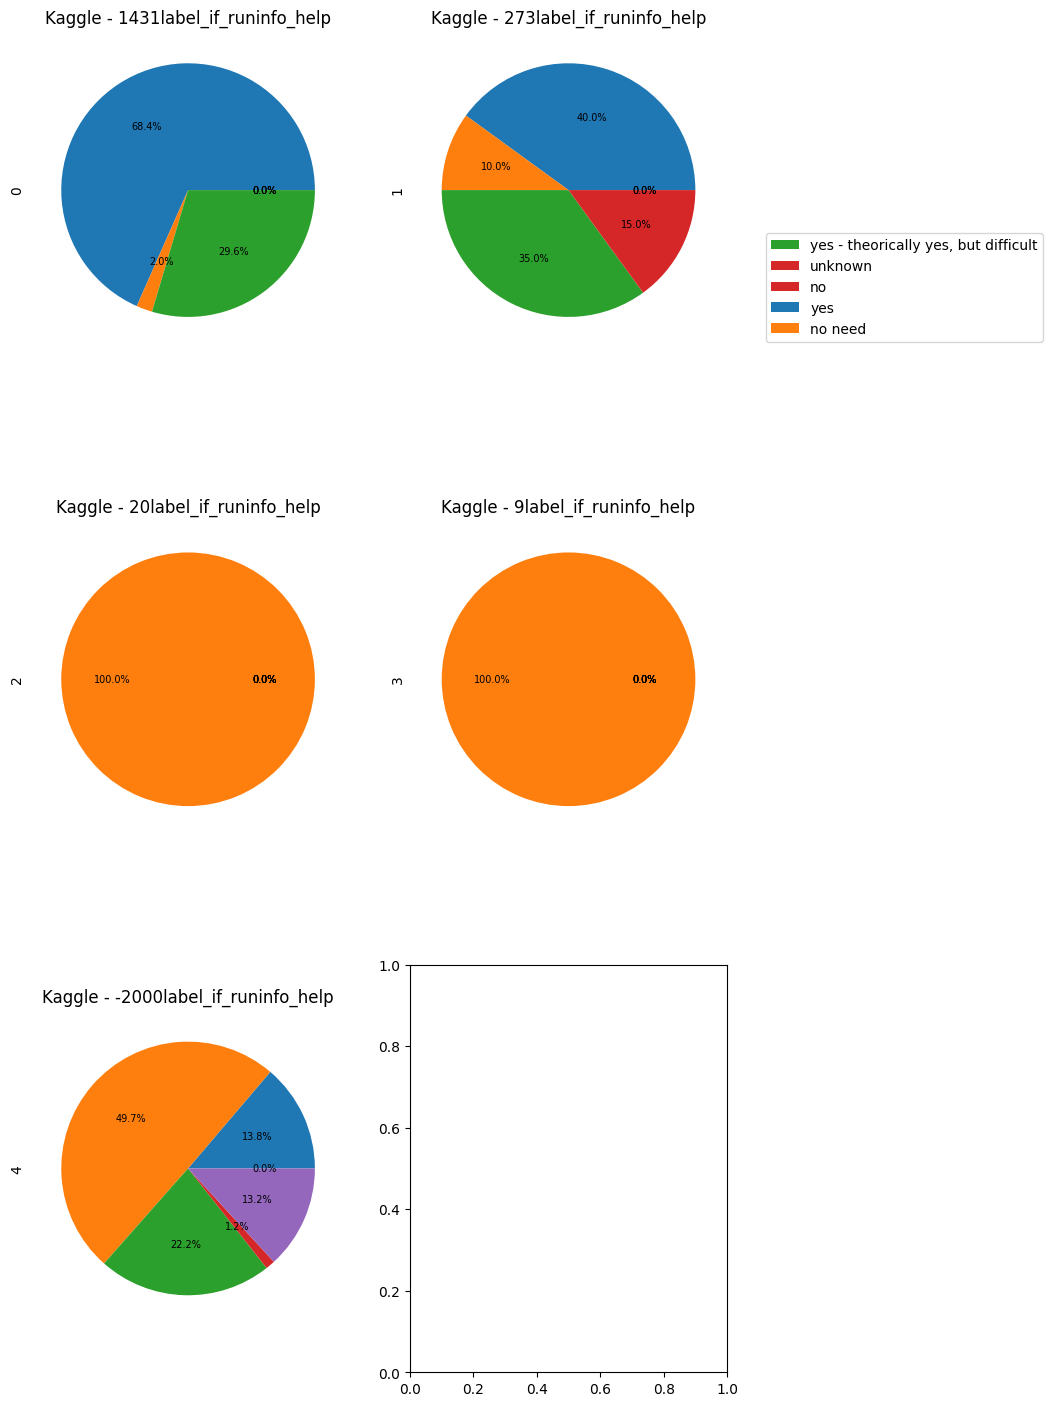

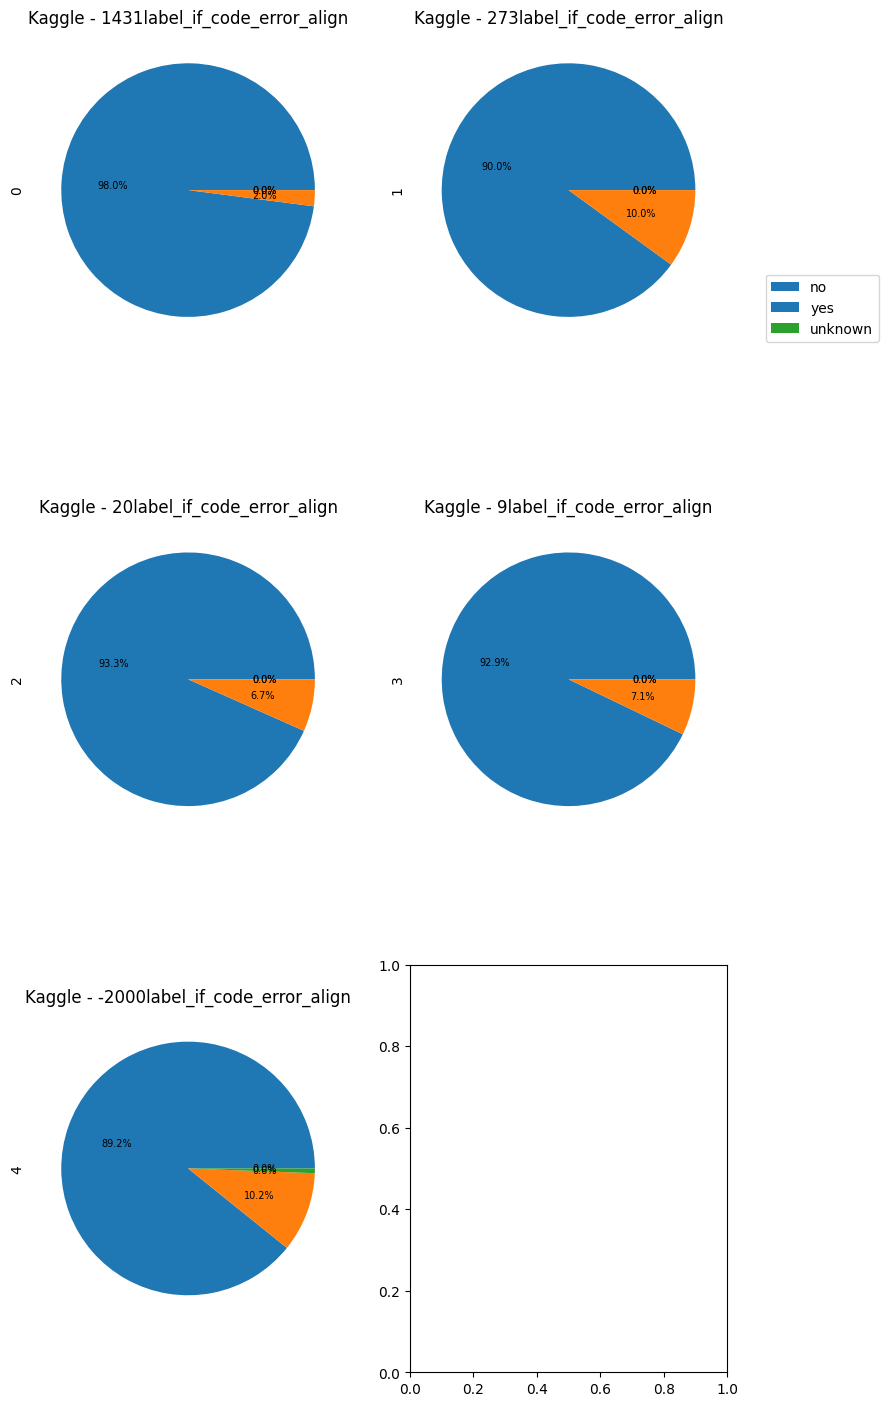

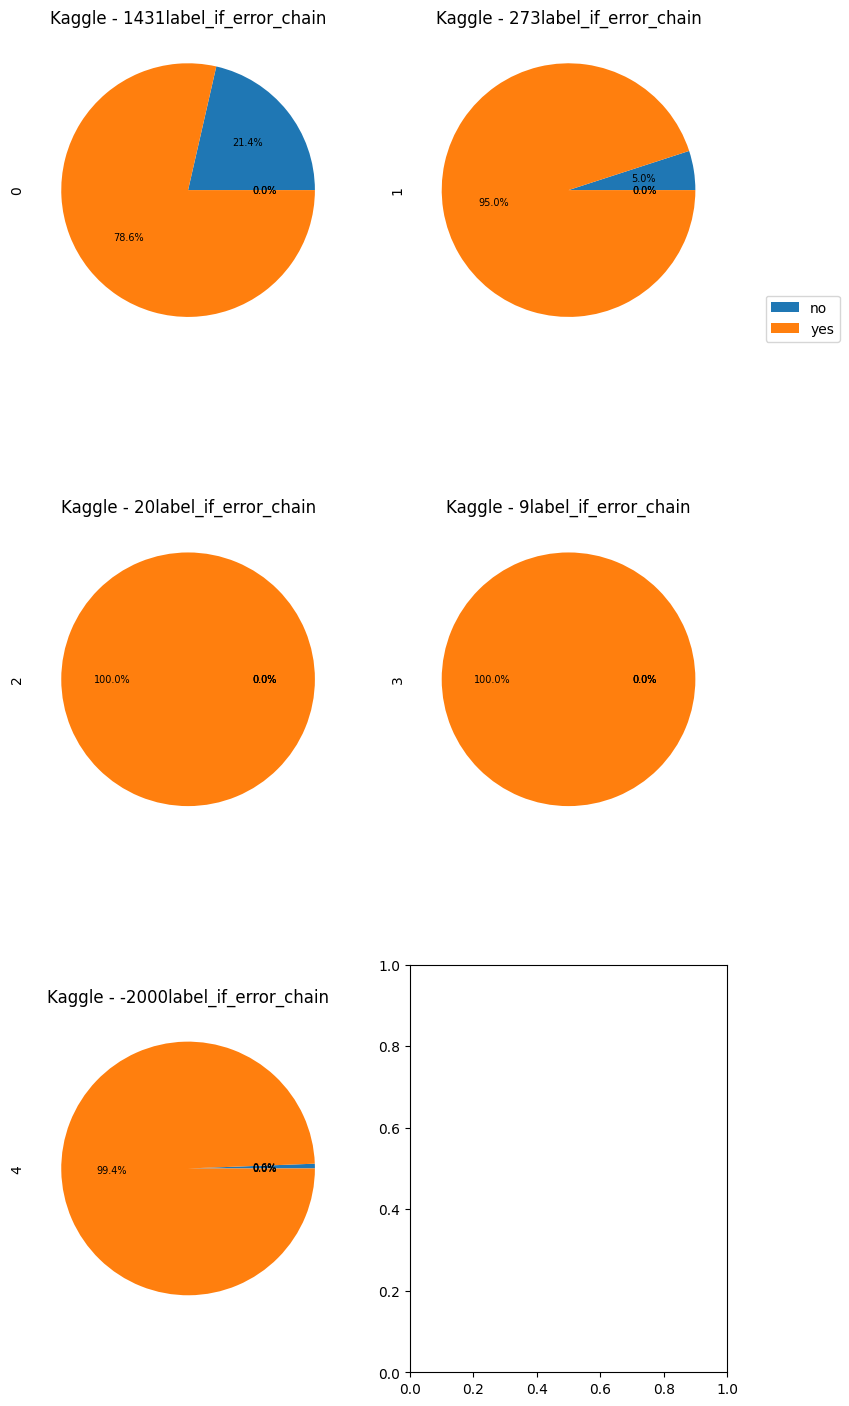

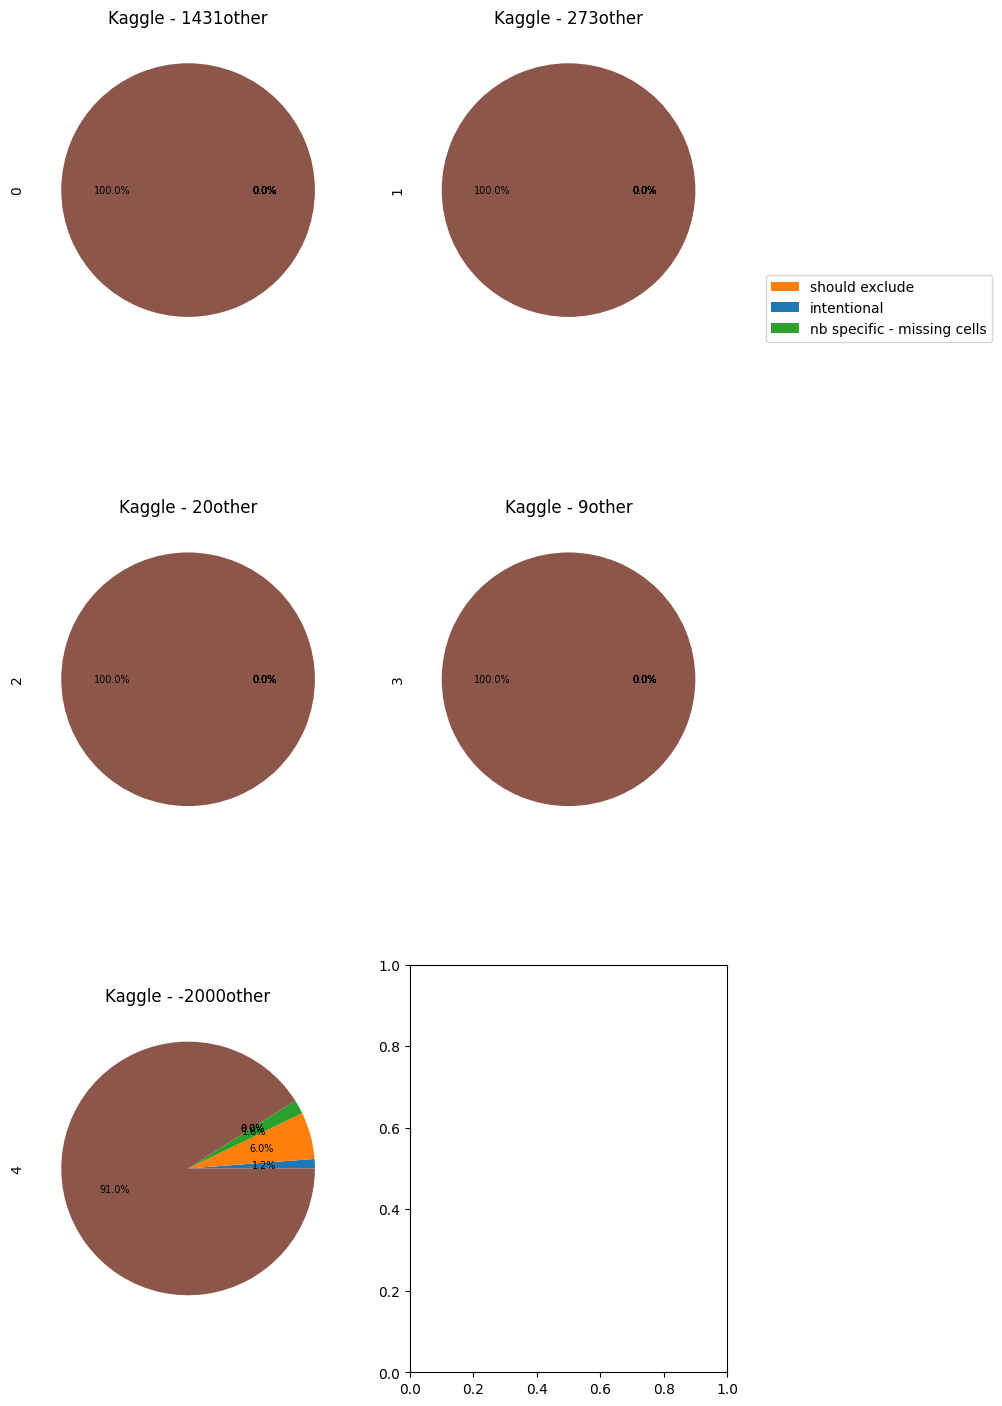

In [164]:
# plot kaggle labels based on clusters
plot_dist_labels_clusters(df_mlerr_label_config, cluster_res_k, source="Kaggle")

In [22]:
# # calculate margin of errors at a confidence level of 95%
# # Moore, D. S. and McCabe G. P. Introduction to the Practice of Statistics. New York: W. H. Freeman, p. 443, 1999.
# # z* sqrt(p(1-p)/sample_size)
# # combine errors across clusters: https://www.met.rdg.ac.uk/~swrhgnrj/combining_errors.pdf

# import math
# import numpy as np

# def moe(p, sn):
#     # Because p^(1−p^) will be close to (but slightly less than) 1/4 when p^ is anywhere near 50%, 
#     #we may conservatively overestimate the standard error even before taking the poll by using 1/4 in the calculation. 
#     #That is, the largest possible standard error of any response in a poll of n observations is sqrt(1/(4n))
#     #need find the reference for this
#     return 1.645 * math.sqrt(p*(1-p)/4/sn) # 0.9-1.645, 0.95-1.96

# def moe_sample(x):
#     if isinstance(x, tuple):
#         if x[1] > 0:
#             return moe(x[0]/x[1], x[1])
#     return 0

# def cal_moe(df_mlerr_label_config, cluster_res):
#     cluster_res_moes = {}
#     for label_key in df_mlerr_label_config:
#         cluster_res_moe = cluster_res[label_key].iloc[:, 1:].map(moe_sample)
#         cluster_res_moes[label_key] = np.sqrt(cluster_res_moe.pow(2).sum()).sort_values(ascending=False)
#     return cluster_res_moes

# def display_df_by_config(df_mlerr_label_config, cluster_df):
#     for label_key in df_mlerr_label_config:
#         display(cluster_df[label_key])

In [11]:
# # calculate variances
# def var(p, n):
#     return n*p*(1-p)

# def var_sample(x):
#     if isinstance(x, tuple):
#         if x[1] > 0:
#             return var(x[0]/x[1], x[1])
#     return 0

# def cal_var(df_mlerr_label_config, cluster_res):
#     cluster_res_vars = {}
#     for label_key in df_mlerr_label_config:
#         cluster_res_var = cluster_res[label_key].iloc[:, 1:].map(var_sample)
#         cluster_res_vars[label_key] = cluster_res_var
#     return cluster_res_vars

# def plot_var_by_config(df_mlerr_label_config, cluster_df):
#     for label_key in df_mlerr_label_config:
#         ax = cluster_df[label_key].plot(title=label_key, ylim=(-3,10), xlabel=None)
#         ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
#         plt.show()

# cluster_res_all_variances = cal_var(df_mlerr_label_config, cluster_res_all)
# plot_var_by_config(df_mlerr_label_config, cluster_res_all_variances)

In [12]:
# # calculate weights based on cluster size
# # assuming the samples represent the cluster population
# def map_element_weights(x):
#     if isinstance(x, tuple):
#         if x[1] > 0:
#             return x[0]/x[1]*x[2]
#         else:
#             return 0
#     else:
#         return x

# # summarize across clusters based on the weights calculated with cluster sizes
# # sorted 
# def cal_weighted_sum(df_mlerr_label_config, cluster_res):
#     cluster_res_weighted_sum = {}
#     for label_key in df_mlerr_label_config:
#         cluster_res_weight = cluster_res[label_key].map(map_element_weights)
#         cluster_res_weighted_sum[label_key] = cluster_res_weight.iloc[:, 1:].sum().sort_values(ascending=False)
#     return cluster_res_weighted_sum

# # plot weighted sum for all categories of labels
# def plot_dist_labels(df_mlerr_label_config, cluster_res_weighted_sum):
#     for label_key in df_mlerr_label_config:
#         ax = cluster_res_weighted_sum[label_key].plot.pie(figsize=(5, 5),
#                                                           legend=True, labeldistance=None,
#                                                           autopct='%1.1f%%', fontsize=7,
#                                                           title = label_key)
#         ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
#         plt.show()

In [12]:
# cluster_res_all = load_statistics(config.path_default.joinpath("data_dedup_cluster/sample2_statistics_all.pickle"))
# for label_key in df_mlerr_label_config:
#     cluster_res_all[label_key] = pd.DataFrame.from_dict(cluster_res_all[label_key]).rename_axis('cluster_id').reset_index()

# cluster_res_all_moes = cal_moe(df_mlerr_label_config, cluster_res_all)
# display_df_by_config(df_mlerr_label_config, cluster_res_all_moes)

In [13]:
# # sampling

# # calculate overall sample size with stratified sampling
# # def sample_size(e):
# #     nh_n = Nh * np.sqrt(Sh2) / sum(Nl*np.sqrt(Sl2))
# #     v = sum(nh_n * (Nh/N)**2 * Sh2)
# #     return 1.96**2 * v/e/e
# def cal_sample_size(cluster_res_variances, cluster_res, df_mlerr_label_config, config_index=0):
#     var_all_ps = cluster_res_variances[df_mlerr_label_config.columns[config_index]]
#     ks = var_all_ps.columns
#     n_k = len(ks)
#     n_h = len(cluster_res[df_mlerr_label_config.columns[config_index]])

#     res_n = []
#     Nh = np.array([i[1][2] for i in cluster_res[df_mlerr_label_config.columns[config_index]][ks[0]].items()])
#     N = sum(Nh)
#     for k in ks:
#         Sh2 = np.array([i[1] for i in var_all_ps[k].items()]) # Nh*0.5*(1-0.5) #

#         with np.errstate(divide='ignore', invalid='ignore'):
#             nh_n = np.divide(Nh * np.sqrt(Sh2),sum(Nh*np.sqrt(Sh2)))
#             nh_n[nh_n == np.inf] = 0
#             nh_n = np.nan_to_num(nh_n)

#             v1 = np.divide(1,nh_n)
#             v1[v1 == np.inf] = 0
#             v1 = np.nan_to_num(v1)

#         v = sum(v1 * ((Nh/N)**2) * Sh2)
#         e = 0.04
#         n = (1.96**2) * v/e/e
#         res_n.append(n)

#     n = max(np.ceil(res_n))
    
#     res_nh = []
#     for k in ks:
#         Sh2 = np.array([i[1] for i in var_all_ps[k].items()])
#         with np.errstate(divide='ignore', invalid='ignore'):
#             nh = np.divide(Nh * np.sqrt(Sh2),sum(Nh*np.sqrt(Sh2))) * n
#             nh[nh == np.inf] = 0
#             nh = np.nan_to_num(nh)
#             res_nh.append(nh)
    
#     return n, res_nh

In [14]:
# config_index = 0
# print("Using the category of", df_mlerr_label_config.columns[config_index])
# cal_sample_size(cluster_res_all_variances, cluster_res_all, df_mlerr_label_config, config_index=config_index)

In [23]:
# cluster_res_g_moes = cal_moe(df_mlerr_label_config, cluster_res_g)
# display_df_by_config(df_mlerr_label_config, cluster_res_g_moes)